In [1]:
# include useful folders
import sys

In [2]:
sys.path.append("../vendors/mtl_girnet/data_prep/")

In [3]:
# enable or disable cuda
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [4]:
import json
import h5py
import numpy as np
import glob
import random
import pandas as pd
import re
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib import pyplot as plt
from keras.preprocessing import sequence

# nltk
import nltk

# tokenizer
from twokenize import tokenizeRawTweetText as tokenize

# for a particular dataset
from xml.dom import minidom

Using TensorFlow backend.


In [5]:
# for trying differnet types of tokenizer

# from nltk.corpus import stopwords
# from  nltk.stem import SnowballStemmer
# from tokensize_deepmoji import tokenize
# from nltk.tokenize import TweetTokenizer
# tokenizer = TweetTokenizer(a)
# from tokenizer import tokenizer
# T = tokenizer.TweetTokenizer(preserve_handles=False, preserve_hashes=False, preserve_case=False, preserve_url=False, regularize=True)
# nltk.download('stopwords')
# stop_words = stopwords.words("english")
# stemmer = SnowballStemmer("english")
# TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
# def preprocess(text, stem=False):
#     # Remove link,user and special characters
#     text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
#     tokens = []
#     for token in text.split():
#         if token not in stop_words: 
#             if stem:
#                 tokens.append(stemmer.stem(token))
#             else:
#                 tokens.append(token)
#     return tokenizer.tokenize(" ".join(tokens))

## Data Preprocessing

### SemEval 2017 Task A

In [6]:
df = pd.read_csv("../data/datastories-semeval2017-task4/dataset/Subtask_A/4A-English/SemEval2017-task4-dev.subtask-A.english.INPUT.txt", sep="\t", header=None)

In [7]:
decode_map = {"negative": -1, "neutral": 0, "positive": 1}

In [8]:
df[1] = df[1].apply(lambda x: decode_map[x])
df[2] = df[2].apply(lambda x: tokenize(x))

In [9]:
data = map( lambda x :{'sentiment': x[1] , 'tokens': x[2] , } , df.to_numpy() )

In [10]:
en_semeval_17 = list(data)

### Sentiment140 dataset 
https://www.kaggle.com/kazanova/sentiment140

In [11]:
# # essential functions/declarations
# decode_map = {0: -1, 2: 0, 4: 1}

In [12]:
# #1.6 millionss tweets dataset
# df = pd.read_csv('../data/'+'training.1600000.processed.noemoticon.csv', encoding='ISO-8859-1' , names=["target", "ids", "date", "flag", "user", "text"])

In [13]:
# # this is goning to take some time. chill 
# df.target = df.target.apply(lambda x: decode_map[int(x)])
# df.text = df.text.apply(lambda x: tokenize(x))

In [14]:
# data = map( lambda x :{'sentiment': x[0] , 'tokens': x[-1] , } , df.to_numpy() )

In [15]:
# en_sentiment140 = list(data)

### English-Spanish Code Mixed Data 

In [16]:
sents = {"N":-1 , "P" :1 , "NONE":0}

In [17]:
data = open("../vendors/mtl_girnet/data_prep/data_cm_senti/cs-corpus-with-tweets_train.txt", encoding='utf-8').read().split("\n") 
data = map( lambda x : x.split("\t") , data )
data = map( lambda x :{'sentiment': sents[x[1]] , 'tokens': tokenize(x[2]) , 'text': x[2] } , data )
en_es_wssa_data_train = data

In [18]:
data = open("../vendors/mtl_girnet/data_prep/data_cm_senti/cs-corpus-with-tweets_test.txt", encoding='utf-8').read().split("\n") 
data = map( lambda x : x.split("\t") , data )
data = map( lambda x :{'sentiment': sents[x[1]] , 'tokens': tokenize(x[2]) , 'text': x[2] } , data )
en_es_wssa_data_test = data

In [19]:
en_es_wssa_data = list(en_es_wssa_data_train) + list(en_es_wssa_data_test)

### Spanish Tweet Dataset

In [20]:
xmldoc = minidom.parse("../vendors/mtl_girnet/data_prep/data_cm_senti/general-tweets-train-tagged.xml")
tweets = xmldoc.getElementsByTagName('tweet')

sents = {"N":-1 , "P" :1 , "NEU":0 , 'NONE':0 , "P+" : 1 , "N+":-1 }


es_tass1_data = []

for i in range( len(tweets)-1) :
    if i == 6055:
        continue # bad jogar
    textt = tweets[i].getElementsByTagName('content')[0].childNodes[0].data
    words = tokenize( textt )
    sentiment = tweets[i].getElementsByTagName('polarity')[0].getElementsByTagName('value')[0].childNodes[0].data
    assert len(tweets[i].getElementsByTagName('polarity')[0].getElementsByTagName('entity'))==0
    es_tass1_data.append({'text':textt , 'tokens':words , 'sentiment': sents[sentiment] })

### Some english tweet data

In [21]:
data = open("../vendors/mtl_girnet/data_prep/data_cm_senti/twitter4242.txt", "r", encoding="utf-8",errors='ignore').read().split("\n")[1:-1]
data = map( lambda x : x.split("\t") , data )
data = map( lambda x :{'sentiment': int(np.sign(int(x[0])-int(x[1]))) , 'tokens': tokenize(x[2]) , 'text': x[2] } , data )

en_twitter_data = list(data)

### es2_twitter_data

In [22]:
data = open("../vendors/mtl_girnet/data_prep/data_cm_senti/1600_tweets_dev_complete.txt", encoding="utf-8").read().split("\n")[1:-1]
data += open("../vendors/mtl_girnet/data_prep/data_cm_senti/1600_tweets_test_average_complete.tsv", encoding="utf-8").read().split("\n")[1:-2]

data = map( lambda x : x.split("\t") , data )
data = map( lambda x :{'sentiment': int(np.sign(int(x[0])-int(x[1]))) , 'tokens': tokenize(x[2]) , 'text': x[2] } , data )

es2_twitter_data = list(data)

In [23]:
print("Code-Mixed: en_es_wssa_data: %d" % len(en_es_wssa_data))
print("Spanish: es2_twitter_data: %d" % len(es2_twitter_data))
print("Spanish: es_tass1_data: %d" % len(es_tass1_data))
print("English: en_twitter_data: %d" % len(en_twitter_data))
# print("English: en_sentiment140: %d" %len(en_sentiment140))

Code-Mixed: en_es_wssa_data: 3062
Spanish: es2_twitter_data: 3202
Spanish: es_tass1_data: 7217
English: en_twitter_data: 4241


## For XLM: Loading data

In [117]:
def get_y(data):
    from keras.utils import to_categorical
    y = []
    for row in data:
        y.append(int(row['sentiment']))
    y = to_categorical(y,num_classes=3)
    return y

In [118]:
es_tass_y = get_y(es_tass1_data)
en_semeval_17_y = get_y(en_semeval_17)

In [120]:
en_semval = np.load('../data/en_semeval_17.vectors.npy')
es_tass = np.load('../data/es_tass1.vectors.npy')

In [121]:
print(en_semval.shape)
print(es_tass.shape)

(20632, 66, 1024)
(7217, 72, 1024)


In [78]:
es_tass[65]

array([[-3.77569914e+00, -6.41775036e+00,  2.47668028e-01, ...,
        -2.25538850e+00,  9.23777771e+00,  1.28983507e+01],
       [-6.73071241e+00, -3.04248333e+00, -1.00528002e-02, ...,
        -6.60611820e+00,  4.97939825e+00,  1.39811873e+00],
       [-6.62404728e+00,  1.75100231e+00,  7.80097961e-01, ...,
        -7.06216717e+00,  7.11820221e+00, -7.77508640e+00],
       ...,
       [-5.91717100e+00, -3.44931889e+00, -1.27766037e+00, ...,
         9.14993584e-01,  3.19174719e+00,  2.00094795e+01],
       [-1.27304876e+00, -8.80142629e-01, -3.26091862e+00, ...,
        -2.13648772e+00,  6.30688477e+00,  1.32532959e+01],
       [-4.94503784e+00, -5.40910053e+00, -1.99482298e+00, ...,
        -7.75677776e+00,  4.38256931e+00,  4.52819109e+00]])

In [122]:
en_semval = en_semval[:,:30,:]
es_tass = es_tass[:,:30,:]

In [53]:
en_semval = sequence.pad_sequences(en_semval, maxlen=20, dtype='float32',padding='post')
es_tass = sequence.pad_sequences(es_tass, maxlen=20, dtype='float32', padding='post')

In [123]:
en_semval[32]

array([[  3.23887348,  -0.75029171,   1.18658292, ...,  -0.79734457,
          1.0380919 ,   1.92190444],
       [  2.19796085,  -5.84797716,   5.26108599, ...,   3.16330433,
         -3.16465569,  -4.93993044],
       [  2.94165897,  -2.0211997 ,  -6.82101107, ...,  -0.57354558,
          4.31726789,   9.0997982 ],
       ...,
       [  0.36065376,  -4.01330137,   2.53680921, ...,  -7.47810221,
         -7.10925102,  14.89376736],
       [ -9.33804035, -12.08189297,   0.46481419, ...,  -1.11138678,
          2.01471424,  14.109025  ],
       [-12.29493809,  -1.46438849,  -4.33274889, ..., -13.63387203,
         -0.9923287 ,  25.40324593]])

## XLM: Model

In [79]:
from keras.layers import *
from keras.models import Sequential
from attention_lstm import AttentionWithContext

In [124]:
EMBEDDING_DIM = en_semval.shape[-1]
MAX_NUM_WORDS = en_semval.shape[-2]
# for cnn_lstm

# Convolution
kernel_size = 5
filters = 64
pool_size = 1

# lstm
lstm_output_size = 70

In [125]:
model = Sequential()
# model.add(Dropout(0.e2))
# model.add(Conv1D(filters,
#                  kernel_size,
#                  activation='relu',
#                  strides=1))
# model.add(MaxPooling1D(pool_size=pool_size))
# model.add(LSTM(lstm_output_size))
model.add((LSTM(512,  input_shape=(MAX_NUM_WORDS, EMBEDDING_DIM), dropout=0.4, recurrent_dropout=0.4)))
# model.add(AttentionWithContext())
# model.add(Dense(1024))
# model.add(Dropout(0.4))
model.add(Dense(128))
model.add(Dropout(0.3))
model.add(Dense(3))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1])


In [126]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 512)               3147776   
_________________________________________________________________
dense_25 (Dense)             (None, 128)               65664     
_________________________________________________________________
dropout_15 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 3)                 387       
_________________________________________________________________
activation_11 (Activation)   (None, 3)                 0         
Total params: 3,213,827
Trainable params: 3,213,827
Non-trainable params: 0
_________________________________________________________________


In [128]:
history = model.fit(en_semval, en_semeval_17_y, batch_size=128, epochs=10, validation_split=0.3, shuffle=True,  initial_epoch=0)

Train on 14442 samples, validate on 6190 samples
Epoch 1/10
14442/14442 [==============================] - 19s 1ms/step - loss: 0.9993 - acc: 0.5083 - f1: 0.4486 - val_loss: 0.8757 - val_acc: 0.5683 - val_f1: 0.5295
Epoch 2/10
14442/14442 [==============================] - 13s 900us/step - loss: 0.8590 - acc: 0.5882 - f1: 0.5594 - val_loss: 0.8121 - val_acc: 0.6069 - val_f1: 0.5817
Epoch 3/10
14442/14442 [==============================] - 13s 930us/step - loss: 0.7923 - acc: 0.6324 - f1: 0.6134 - val_loss: 0.8159 - val_acc: 0.6186 - val_f1: 0.6093
Epoch 4/10
14442/14442 [==============================] - 12s 854us/step - loss: 0.7496 - acc: 0.6566 - f1: 0.6440 - val_loss: 0.7831 - val_acc: 0.6318 - val_f1: 0.6241
Epoch 5/10
14442/14442 [==============================] - 12s 850us/step - loss: 0.7248 - acc: 0.6693 - f1: 0.6546 - val_loss: 0.7850 - val_acc: 0.6342 - val_f1: 0.6273
Epoch 6/10
14442/14442 [==============================] - 12s 853us/step - loss: 0.6926 - acc: 0.6865 - f1: 

dict_keys(['val_loss', 'loss', 'val_f1', 'val_acc', 'acc', 'f1'])


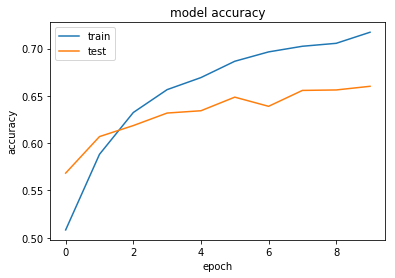

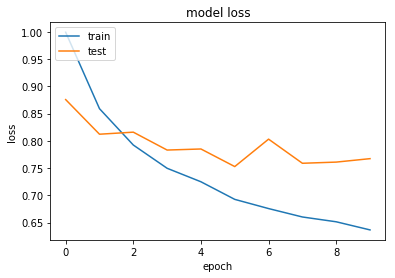

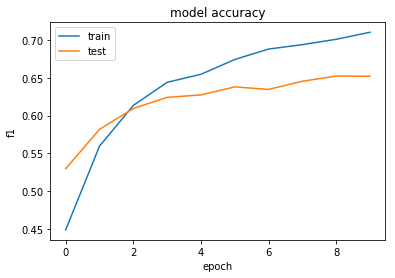

In [129]:
plot_history(history)

In [130]:
def evaluate_one(model, x, y):
    y_pred = model.predict(x,verbose=0)
    print("Classification Report")
    print(classification_report(np.argmax(y, axis=1), np.argmax(y_pred,axis=1)))
    print("Confusion Matrix")
    print(confusion_matrix(np.argmax(y, axis=1), np.argmax(y_pred,axis=1)))

evaluate_one(model, es_tass, es_tass_y)

Classification Report
              precision    recall  f1-score   support

           0       0.40      0.74      0.52      2152
           1       0.78      0.47      0.58      2883
           2       0.67      0.45      0.54      2182

   micro avg       0.54      0.54      0.54      7217
   macro avg       0.62      0.55      0.55      7217
weighted avg       0.63      0.54      0.55      7217

Confusion Matrix
[[1595  288  269]
 [1325 1348  210]
 [1109   94  979]]


In [134]:
history = model.fit(es_tass, es_tass_y, batch_size=128, epochs=15, validation_split=0.3, shuffle=True,  initial_epoch=10)

Train on 5051 samples, validate on 2166 samples
Epoch 11/15
5051/5051 [==============================] - 4s 869us/step - loss: 0.6525 - acc: 0.7171 - f1: 0.7045 - val_loss: 0.8185 - val_acc: 0.6653 - val_f1: 0.6561
Epoch 12/15
5051/5051 [==============================] - 4s 881us/step - loss: 0.6419 - acc: 0.7244 - f1: 0.7066 - val_loss: 0.8603 - val_acc: 0.6519 - val_f1: 0.6373
Epoch 13/15
5051/5051 [==============================] - 4s 847us/step - loss: 0.6130 - acc: 0.7424 - f1: 0.7315 - val_loss: 0.8356 - val_acc: 0.6496 - val_f1: 0.6392
Epoch 14/15
5051/5051 [==============================] - 4s 830us/step - loss: 0.6029 - acc: 0.7432 - f1: 0.7360 - val_loss: 0.8676 - val_acc: 0.6454 - val_f1: 0.6332
Epoch 15/15
5051/5051 [==============================] - 4s 853us/step - loss: 0.5853 - acc: 0.7450 - f1: 0.7366 - val_loss: 0.9173 - val_acc: 0.6537 - val_f1: 0.6473


dict_keys(['val_loss', 'loss', 'val_f1', 'val_acc', 'acc', 'f1'])


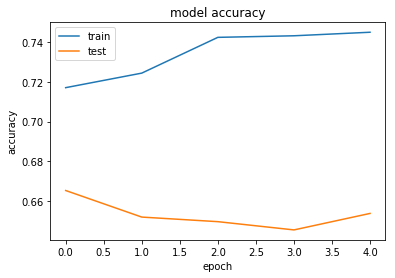

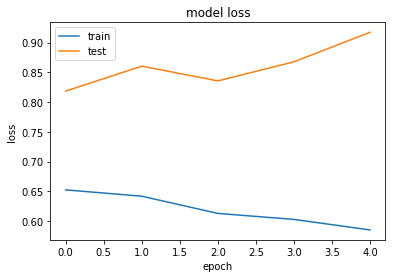

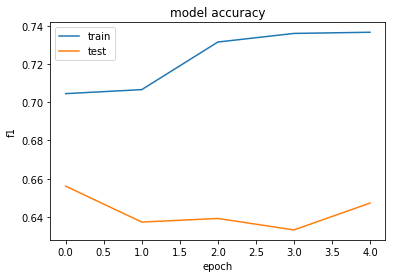

In [135]:
plot_history(history)

# For Reading And Writing Data

In [21]:
def write_sentences(data, name, has_text=True):
    with open(name,"w") as f:
        temp = ""
        for row in data:
            if has_text:
                temp = temp + str(row['text']).strip().replace("\n"," ") + "\n"
            else:
                temp = temp + str(" ".join(row['tokens'])).strip() + "\n"
        f.write(temp)

def write_sentences_sep(data, name):
    with open(name,"w") as f:
        temp = []
        for row in data:
            temp.append(str(" ".join(row['tokens'])).strip() + "\n")
    return temp

In [26]:
write_sentences(en_es_wssa_data,"en_es.txt")
write_sentences(es2_twitter_data,"es2_twitter.txt")
write_sentences(es_tass1_data,"es_tass1.txt")
write_sentences(en_twitter_data, "en_twiter.txt")
write_sentences(en_semeval_17, "en_semeval_17.txt", False)

In [ ]:
# PRLEASE DON'T EXECUTE THIS MOTHERFUCKER
lines_ = write_sentences_sep(en_sentiment140, "en_sentiment140.txt")
with open("en_sentiment140.txt", "w") as f:
    for line in lines_:
        f.write(line)

In [24]:
def get_y(data):
    from keras.utils import to_categorical
    y = []
    for row in data:
        y.append(int(row['sentiment']))
    y = to_categorical(y,num_classes=3)
    return y

In [25]:
en_es_y =  get_y(en_es_wssa_data)
es_twitter_y = get_y(es2_twitter_data)
es_tass_y = get_y(es_tass1_data)
en_twitter_y = get_y(en_twitter_data)
en_semeval_17_y = get_y(en_semeval_17)
# en_sentiment140_y = get_y(en_sentiment140)

Using TensorFlow backend.


In [26]:
def load(file):
    dim = 1024
    X = np.fromfile(file, dtype=np.float32, count=-1)    
    X.resize(X.shape[0] // dim, dim) 
    print(file + ": " + str(X.shape))
    return X

In [27]:
es_tass_emb =load("es_tass1.raw")

es_tass1.raw: (7217, 1024)


In [28]:
en_es_emb = load("en_es.raw")
es_twitter_emb =load("es2_twitter.raw")
es_tass_emb =load("es_tass1.raw")
en_twitter_emb =load("en_twiter.raw")
# en_sentiment140_emb = load("en_sentiment140.raw")
en_semeval_17_em = load("en_semeval_17.raw")

en_es.raw: (3062, 1024)
es2_twitter.raw: (3202, 1024)
es_tass1.raw: (7217, 1024)
en_twiter.raw: (4241, 1024)
en_semeval_17.raw: (20632, 1024)


In [29]:
es_tass_y.shape

(7217, 3)

## Functions IMP

In [32]:
def plot_history(history):
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['f1'])
    plt.plot(history.history['val_f1'])
    plt.title('model accuracy')
    plt.ylabel('f1')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [33]:
from keras import backend as K


def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.
        Only computes a batch-wise average of recall.
        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.
        Only computes a batch-wise average of precision.
        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [34]:
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
def get_class_weight(y):
    """
    Used from: https://stackoverflow.com/a/50695814
    TODO: check validity and 'balanced' option
    :param y: A list of one-hot-encoding labels [[0,0,1,0],[0,0,0,1],..]
    :return: class-weights to be used by keras model.fit(.. class_weight="") -> {0:0.52134, 1:1.adas..}
    """
    y_integers = np.argmax(y, axis=1)
    class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
    d_class_weights = dict(enumerate(class_weights))
    return d_class_weights